In [4]:

import os
import pandas as pd
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

In [54]:
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [30]:
dir = r"C:\Users\KRP\Programming\School\AiCphBusiness\MachineLearning\Assignment4\CNN\train" + "\\"

In [26]:


image_dir = os.getcwd()+"\\CNN\\train\\"
image_dir = dir
filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels, "img": img})

for index, row in data.iterrows():
    img = imread(image_dir + row["filename"])
    img = resize(img, (80,80))
    data.loc[index, "img"] = img

data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5533 non-null   int64 
 1   filename  5533 non-null   object
 2   label     5533 non-null   object
 3   img       5533 non-null   object
dtypes: int64(1), object(3)
memory usage: 173.0+ KB


In [28]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

i = 0
j = 0 

while (i < 10):
    
    filename =  'dog.' + str(j) + '.jpg'
    j += 1
    if(os.path.exists(os.getcwd()+"\\CNN\\train\\"+filename) == False):
        continue

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    i += 1

    image = imread("CNN\\train\\"+filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

KeyboardInterrupt: 

<Figure size 2000x2000 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

i = 0
j = 0 

while (i < 10):
    
    filename =  'cat.' + str(j) + '.jpg'
    j += 1
    if(os.path.exists(os.getcwd()+"\\CNN\\train\\"+filename) == False):
        continue

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    i += 1

    image = imread("CNN\\train\\"+filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

In [46]:
train_images, test_images,train_labels, test_labels = train_test_split(
    np.array(data["img"]), 
    np.array(data["label"]), 
    random_state=42, 
    test_size=0.3)

train_images, test_images = train_images / 255.0, test_images / 255.0

In [49]:
train_df, test_df = train_test_split(data, test_size=0.3)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming you have a directory with training images stored in 'train_directory'
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
    directory=dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'  # or 'categorical' based on your problem
)



Found 3873 validated image filenames belonging to 2 classes.


In [50]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'  # or 'categorical'
)

Found 1660 validated image filenames belonging to 2 classes.


In [51]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = model.fit(train_generator,validation_data = test_generator, epochs=30, lr)

C:\Users\KRP\Programming\School\AiCphBusiness\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


C:\Users\KRP\Programming\School\AiCphBusiness\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 373ms/step - accuracy: 0.5007 - loss: 0.7635 - val_accuracy: 0.5211 - val_loss: 0.6922
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 405ms/step - accuracy: 0.5382 - loss: 0.6904 - val_accuracy: 0.5608 - val_loss: 0.6877
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 69s 560ms/step - accuracy: 0.5578 - loss: 0.6873 - val_accuracy: 0.5861 - val_loss: 0.6681
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy: 0.5569 - loss: 0.6794 - val_accuracy: 0.5693 - val_loss: 0.6843
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.5577 - loss: 0.6837 - val_accuracy: 0.5795 - val_loss: 0.6659
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 243ms/step - accuracy: 0.5794 - loss: 0.6710 - val_accuracy: 0.5729 - val_loss: 0.6811
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 36s 293ms/step - accuracy: 0.5806 - loss: 0.6668 - val_accuracy: 0.6114 - val_loss: 0.6468
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.6093 - loss: 0.6602 - val

In [55]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Added a deeper layer
    MaxPooling2D(2, 2),                     # Additional pooling layer
    Flatten(),
    Dropout(0.5),                           # Dropout for regularization
    Dense(512, activation='relu'),
    Dropout(0.5),                           # Another dropout layer before the final classification layer
    Dense(2, activation='softmax')          # Using softmax for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model2 = model.fit(train_generator,validation_data = test_generator, epochs=30, learning)

C:\Users\KRP\Programming\School\AiCphBusiness\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.5131 - loss: 0.7059 - val_accuracy: 0.4940 - val_loss: 0.6963
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.5495 - loss: 0.6861 - val_accuracy: 0.5307 - val_loss: 0.6810
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - accuracy: 0.5495 - loss: 0.6812 - val_accuracy: 0.5892 - val_loss: 0.6665
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.5827 - loss: 0.6745 - val_accuracy: 0.6181 - val_loss: 0.6539
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.5693 - loss: 0.6812 - val_accuracy: 0.6307 - val_loss: 0.6492
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.5629 - loss: 0.6791 - val_accuracy: 0.5976 - val_loss: 0.6588
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.5670 - loss: 0.6797 - val_accuracy: 0.5771 - val_loss: 0.6704
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5689 - loss: 0

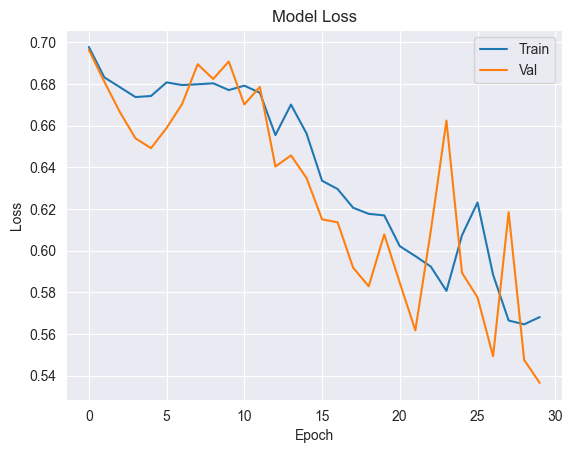

In [57]:
plt.plot(trained_model2.history['loss'])
plt.plot(trained_model2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()